In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 3) CAMINHOS DAS PASTAS
TRAIN_DIR = 'G:\Meu Drive\cancer_treino'           # ou '/content/drive/MyDrive/datasets/cancer_treino'
VAL_DIR   = 'G:\Meu Drive\carcer_val'
TEST_DIR  = 'G:\Meu Drive\cancer_teste'


IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
# 4) CRIAR DATASETS
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 35546 files belonging to 2 classes.
Found 7216 files belonging to 2 classes.
Found 4803 files belonging to 2 classes.


In [4]:
# 5) VERIFICAR CLASSES DETECTADAS
class_names = train_ds.class_names
print("Classes detectadas:", class_names)
print("=> 0 =", class_names[0], " (Baixa sugestão de investigação)")
print("=> 1 =", class_names[1], " (Alta sugestão de investigação)")

Classes detectadas: ['benigno', 'maligno']
=> 0 = benigno  (Baixa sugestão de investigação)
=> 1 = maligno  (Alta sugestão de investigação)


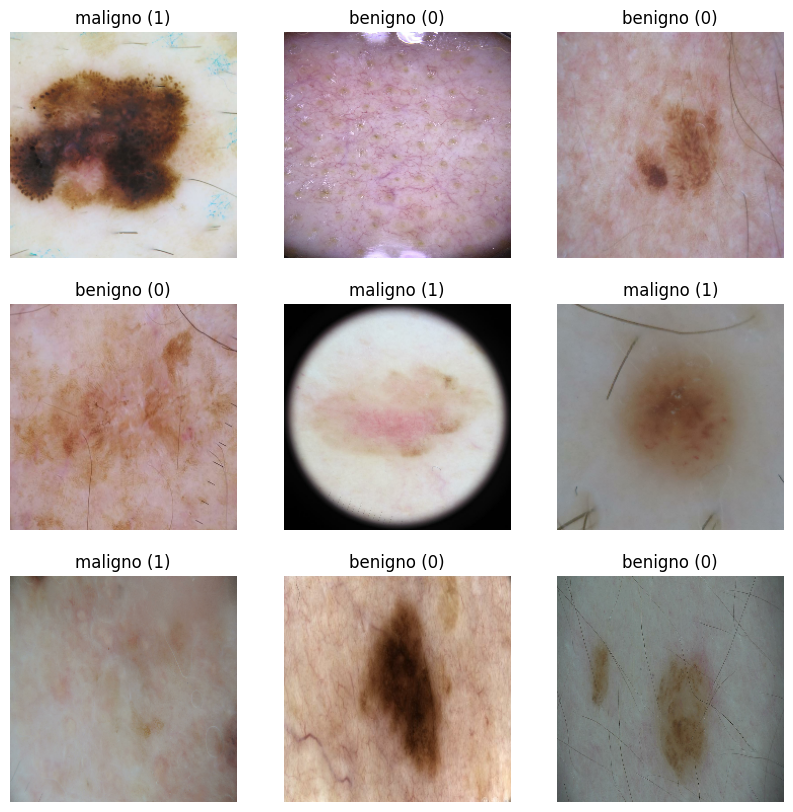

In [5]:
# 6) MOSTRAR ALGUMAS IMAGENS DE TREINO
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[int(labels[i])]} ({int(labels[i])})")
        plt.axis("off")
plt.show()

In [6]:
# 7) CACHE E PREFETCH
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# 8) DATA AUGMENTATION
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [8]:
# 10) MODELO BASE
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# 11) CALLBACKS
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint_path = '/content/best_model.h5'
callbacks = [
    EarlyStopping(monitor='val_auc', patience=6, mode='max', restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_auc', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max')
]

In [10]:
# 12) TREINO FASE 1
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6290 - auc: 0.6683 - loss: 0.6368

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 2288s 2s/step - accuracy: 0.6290 - auc: 0.6683 - loss: 0.6368 - val_accuracy: 0.6553 - val_auc: 0.7347 - val_loss: 0.6127 - learning_rate: 1.0000e-04
Epoch 2/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7267 - auc: 0.7866 - loss: 0.5509

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 331s 298ms/step - accuracy: 0.7267 - auc: 0.7866 - loss: 0.5509 - val_accuracy: 0.6721 - val_auc: 0.7594 - val_loss: 0.5993 - learning_rate: 1.0000e-04
Epoch 3/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7387 - auc: 0.8049 - loss: 0.5285

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 317s 285ms/step - accuracy: 0.7388 - auc: 0.8049 - loss: 0.5285 - val_accuracy: 0.6786 - val_auc: 0.7680 - val_loss: 0.5950 - learning_rate: 1.0000e-04
Epoch 4/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7514 - auc: 0.8179 - loss: 0.5142

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 344s 310ms/step - accuracy: 0.7514 - auc: 0.8179 - loss: 0.5142 - val_accuracy: 0.6810 - val_auc: 0.7718 - val_loss: 0.5937 - learning_rate: 1.0000e-04
Epoch 5/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7581 - auc: 0.8258 - loss: 0.5038

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 326s 294ms/step - accuracy: 0.7581 - auc: 0.8258 - loss: 0.5038 - val_accuracy: 0.6842 - val_auc: 0.7741 - val_loss: 0.5940 - learning_rate: 1.0000e-04
Epoch 6/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7582 - auc: 0.8267 - loss: 0.5007

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 345s 310ms/step - accuracy: 0.7582 - auc: 0.8267 - loss: 0.5007 - val_accuracy: 0.6856 - val_auc: 0.7746 - val_loss: 0.5918 - learning_rate: 1.0000e-04
Epoch 7/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7635 - auc: 0.8314 - loss: 0.4967

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 320s 288ms/step - accuracy: 0.7635 - auc: 0.8314 - loss: 0.4967 - val_accuracy: 0.6879 - val_auc: 0.7749 - val_loss: 0.5908 - learning_rate: 1.0000e-04
Epoch 8/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7629 - auc: 0.8342 - loss: 0.4921

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 307s 277ms/step - accuracy: 0.7629 - auc: 0.8342 - loss: 0.4921 - val_accuracy: 0.6874 - val_auc: 0.7755 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 9/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.7643 - auc: 0.8344 - loss: 0.4910

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 308s 277ms/step - accuracy: 0.7643 - auc: 0.8344 - loss: 0.4910 - val_accuracy: 0.6863 - val_auc: 0.7757 - val_loss: 0.5933 - learning_rate: 1.0000e-04
Epoch 10/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 309s 279ms/step - accuracy: 0.7678 - auc: 0.8350 - loss: 0.4901 - val_accuracy: 0.6863 - val_auc: 0.7756 - val_loss: 0.5955 - learning_rate: 1.0000e-04


In [11]:
# Calcular pesos das classes automaticamente
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)

# Converter para inteiro e achatar o array (transformar [[0], [1]] → [0, 1])
y_train = y_train.astype(int).ravel()

from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos balanceados
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Transformar em dicionário {classe: peso}
class_weights = {int(c): w for c, w in zip(np.unique(y_train), class_weights_array)}

print("Pesos das classes:", class_weights)


Pesos das classes: {0: np.float64(1.1230254012384684), 1: np.float64(0.9012677484787018)}


In [12]:
# 13) FINE-TUNING
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,  # agora definido corretamente
    callbacks=callbacks
)

Epoch 1/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7394 - auc: 0.8058 - loss: 0.5365

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 456s 397ms/step - accuracy: 0.7394 - auc: 0.8058 - loss: 0.5365 - val_accuracy: 0.6867 - val_auc: 0.7812 - val_loss: 0.6192 - learning_rate: 1.0000e-05
Epoch 2/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7730 - auc: 0.8473 - loss: 0.4796

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 411s 370ms/step - accuracy: 0.7730 - auc: 0.8473 - loss: 0.4796 - val_accuracy: 0.6997 - val_auc: 0.7927 - val_loss: 0.6199 - learning_rate: 1.0000e-05
Epoch 3/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7904 - auc: 0.8656 - loss: 0.4528

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 424s 381ms/step - accuracy: 0.7904 - auc: 0.8656 - loss: 0.4528 - val_accuracy: 0.7041 - val_auc: 0.8009 - val_loss: 0.6298 - learning_rate: 1.0000e-05
Epoch 4/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7956 - auc: 0.8746 - loss: 0.4377

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 415s 374ms/step - accuracy: 0.7956 - auc: 0.8747 - loss: 0.4377 - val_accuracy: 0.7090 - val_auc: 0.8043 - val_loss: 0.6281 - learning_rate: 1.0000e-05
Epoch 5/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8019 - auc: 0.8812 - loss: 0.4261

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 418s 377ms/step - accuracy: 0.8019 - auc: 0.8812 - loss: 0.4261 - val_accuracy: 0.7100 - val_auc: 0.8091 - val_loss: 0.6343 - learning_rate: 1.0000e-05
Epoch 6/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8092 - auc: 0.8853 - loss: 0.4192

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 417s 375ms/step - accuracy: 0.8092 - auc: 0.8853 - loss: 0.4192 - val_accuracy: 0.7148 - val_auc: 0.8111 - val_loss: 0.6340 - learning_rate: 1.0000e-05
Epoch 7/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8129 - auc: 0.8889 - loss: 0.4131

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 424s 381ms/step - accuracy: 0.8129 - auc: 0.8889 - loss: 0.4131 - val_accuracy: 0.7167 - val_auc: 0.8138 - val_loss: 0.6419 - learning_rate: 1.0000e-05
Epoch 8/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8166 - auc: 0.8955 - loss: 0.4019

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 427s 384ms/step - accuracy: 0.8166 - auc: 0.8956 - loss: 0.4019 - val_accuracy: 0.7191 - val_auc: 0.8165 - val_loss: 0.6415 - learning_rate: 1.0000e-05
Epoch 9/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8199 - auc: 0.8964 - loss: 0.4000

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 425s 382ms/step - accuracy: 0.8199 - auc: 0.8964 - loss: 0.4000 - val_accuracy: 0.7226 - val_auc: 0.8166 - val_loss: 0.6396 - learning_rate: 1.0000e-05
Epoch 10/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8210 - auc: 0.9003 - loss: 0.3932

1111/1111 ━━━━━━━━━━━━━━━━━━━━ 427s 384ms/step - accuracy: 0.8210 - auc: 0.9003 - loss: 0.3932 - val_accuracy: 0.7228 - val_auc: 0.8195 - val_loss: 0.6469 - learning_rate: 1.0000e-05


In [13]:
# 14) AVALIAÇÃO FINAL
results = model.evaluate(test_ds)
print("Resultados (loss, AUC, acc):", results)

151/151 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7585 - auc: 0.4569 - loss: 0.5158
Resultados (loss, AUC, acc): [0.5499128699302673, 0.8530530333518982, 0.7372475266456604]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

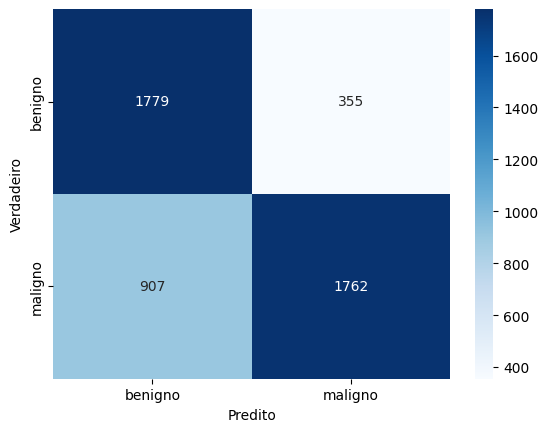

Relatório de classificação:
              precision    recall  f1-score   support

     benigno       0.66      0.83      0.74      2134
     maligno       0.83      0.66      0.74      2669

    accuracy                           0.74      4803
   macro avg       0.75      0.75      0.74      4803
weighted avg       0.76      0.74      0.74      4803



In [14]:
# 15) MÉTRICAS DETALHADAS
y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.reshape(-1).tolist())

roc = roc_auc_score(y_true, y_pred)
print("ROC AUC (teste):", roc)

y_pred_bin = [1 if p >= 0.5 else 0 for p in y_pred]
print("Matriz de confusão:")
cm = confusion_matrix(y_true, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

print("Relatório de classificação:")
print(classification_report(y_true, y_pred_bin, target_names=class_names))

In [38]:
# 17) TESTE RÁPIDO COM UMA IMAGEM
from PIL import Image
import numpy as np

def prever_imagem(caminho_img):
    img = Image.open(caminho_img).convert('RGB').resize((224, 224))
    arr = np.array(img).astype('float32') / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0][0]
    label = 'Alta sugestão de investigação (maligno)' if pred >= 0.5 else 'Baixa sugestão de investigação (benigno)'
    print(f"{caminho_img} → {label} | confiança: {pred:.3f}")

# Chamar a função
prever_imagem("img.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
img.jpg → Baixa sugestão de investigação (benigno) | confiança: 0.489


In [26]:
model.save_weights('pesos_modelo_1_cancer.weights.h5')


In [29]:
model.save("modelo_2_cancer.keras")


In [30]:
model.export("modelo_3_cancer")


INFO:tensorflow:Assets written to: modelo_3_cancer\assets


INFO:tensorflow:Assets written to: modelo_3_cancer\assets


Saved artifact at 'modelo_3_cancer'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2347054651472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054651280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054649936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054652432: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2347054651856: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2347054649744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054653968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054654928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054654160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054651088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347054655888: T

In [35]:
import tensorflow as tf
import tf2onnx

# Cria uma assinatura com o tamanho que seu modelo espera
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

# Converter para ONNX
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13
)

with open("modelo_cancer.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

print("✅ Modelo convertido para ONNX com sucesso!")


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000022277753600>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Modelo convertido para ONNX com sucesso!
